In [2]:
# librerías tipicas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

# librerías modelos
from scipy.stats import norm
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_samples,silhouette_score, v_measure_score
# from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

In [3]:
path_df = "Datasets/Datos.xlsx"

In [4]:
class Procesamiento:

  VARIABLES = ["Fecha","ID","Edad","Analisis","Desarrollo","Programacion","Necesidades","Oratoria","Matematica","Estadistica"]
  SUBSET_VARS = ["ID","Analisis","Desarrollo","Programacion","Necesidades","Oratoria","Matematica","Estadistica"]

  def __init__(self,path):
    self.path = path
    self.random_state = 100
  
  def read_excel(self):
    xl = pd.ExcelFile(self.path)
    df = xl.parse(0, header=None, names=Procesamiento.VARIABLES)
    df.drop(df.index[0],inplace=True)
    self.df_clean = df

  def preselccion(self):
    df = self.df_clean.copy()
    df =df[Procesamiento.SUBSET_VARS]
    self.subset = df

  def limpieza(self):
    df = self.subset.copy()
    for var in Procesamiento.SUBSET_VARS:
      df[var] = df[var].astype(int)
    return df

  def applicar_proceso(self):
    self.read_excel()
    self.preselccion()
    self.subset = self.limpieza()
    self.escalado()
    self.data_modelo = self.subset.copy()

  def grafico_distribucion(self,datos,columnas):
    fig=plt.figure(figsize=(20,30))
    for i, feature in enumerate(columnas):
        ax=fig.add_subplot(10,2,i+1)
        sns.distplot(datos[feature], bins=14, kde=False)
        ax.set_title(feature+" Distribution")

    fig.tight_layout()  
    plt.show()

  def grafico_uno(self,datos,var1,var2,multiple=False):
    if multiple==True:
      for i,var in enumerate(var2):
        plt.figure(figsize=(12,10))
        plt.subplot(320+(i+1))
        plt.scatter(y=datos[var1], x=datos[var],alpha=0.5, edgecolor='k')

    else:
      plt.figure(figsize=(8,6))
      plt.scatter(datos[var1], datos[var2],alpha=0.5, edgecolor='k')
      plt.title('Distribución ', fontsize=16)

    plt.xlabel(var1, fontsize=14)
    plt.xticks(fontsize=12)
    plt.ylabel(var2, fontsize=14)
    plt.yticks(fontsize=12)
    plt.show()
  
  def correlacion(self,plot=True):
    corr = process.subset.corr()
    if plot==True:
      return corr.style.background_gradient(cmap='coolwarm').set_precision(2)
    else:
      return corr
  
  def escalado(self):
    scaler = StandardScaler()
    km_scale = scaler.fit_transform(self.subset.drop(["ID"],axis=1))
    self.escalados = km_scale
  
  def modelos(self,modelo, *args, **kwargs):

    if modelo=="kmeans":
      self.model = KMeans(*args, **kwargs,random_state = self.random_state, init="random")
      
    elif modelo=="jerarquico":
      self.model = AgglomerativeClustering(*args, **kwargs)    
    
    elif modelo=="dbscan":
      self.model = DBSCAN(*args, **kwargs)

    elif modelo=="PCA":
      pca = PCA(*args, **kwargs)
      self.pca_model = pca
      self.escalados = pca.fit_transform(self.escalados)

    elif modelo=="KNN":
      knn = NearestNeighbors(*args, **kwargs)
      knn.fit(self.escalados)
      self.knn_model = knn

      distances, indices = knn.kneighbors(self.escalados)
      self.knn_distances = distances
      self.knn_indices = indices

    else:
      print("Seleccion un modelo valido")
    
    if (modelo!="PCA") and (modelo!="KNN"):
      self.model.fit_predict(self.escalados)
      self.data_modelo[modelo] = self.model.labels_
    
  def data_metodo_codo(self,*args, **kwargs):
    ssw = []
    K = range(1,10)
    for k in K:
      self.modelos(*args, **kwargs,n_clusters=k)        
      ssw.append(self.model.inertia_)
   
    plt.figure(figsize=(12,8))
    plt.plot(range(1,10), ssw, 'bx-')
    plt.xlabel('Número de clusters $k$')
    plt.ylabel('Suma de cuadrados dentro')
    plt.title('El método del codo mostrando el k óptimo')
    plt.show()
  
  def data_silueta(self,*args,**kwargs):
    scores = [0]
    for k in range(2,11):
      self.modelos(*args, **kwargs,n_clusters=k)
      score = silhouette_score(self.escalados,self.model.labels_)
      scores.append(score)
    
    plt.figure(figsize=(11,8.5))
    plt.plot(range(1,11), np.array(scores), 'bx-')
    plt.xlabel('Número de clusters $k$')
    plt.ylabel('Average Silhouette')
    plt.title('Método Silhouette mostrando el $k$ óptimo')
    plt.show()

  def boxplot_full(self,var):
    datos = self.data_modelo
    f, axes = plt.subplots(2, 4)
    f.set_figheight(10)
    f.set_figwidth(10)
    sns.boxplot(  y="Analisis", x= var, data=datos,  orient='v' , ax=axes[0,0])
    sns.boxplot(  y="Desarrollo", x= var, data=datos,  orient='v' , ax=axes[0,1])
    sns.boxplot(  y="Programacion", x= var, data=datos,  orient='v' , ax=axes[0,2])
    sns.boxplot(  y="Necesidades", x= var, data=datos,  orient='v' , ax=axes[0,3])
    sns.boxplot(  y="Oratoria", x= var, data=datos,  orient='v' , ax=axes[1,0])
    sns.boxplot(  y="Matematica", x= var, data=datos,  orient='v' , ax=axes[1,1])
    sns.boxplot(  y="Estadistica", x= var, data=datos,  orient='v' , ax=axes[1,2])
    plt.show()
  
  def final_teams(self,lists):
    a = [x for t in zip(*lists) for x in t]
    equipo = []
    for i,b in enumerate(a):
        if i==0:        
            equipo.append(1)
        elif (i%3==0) and (i!=0):
            
            equipo.append(equipo[i-1]+1)
        else:
            # print(equipo[i-1])
            equipo.append(equipo[i-1])

    dict_grupos = dict(zip(a,equipo))
    dict_grupos[lists[2][-1]] = 7
    dict_grupos[lists[0][6]] = 7
    dict_grupos[lists[0][7]] = 8
    dict_grupos[lists[0][8]] = 8
    self.data_modelo["group_n_n"] = self.data_modelo["ID"].apply(lambda x: dict_grupos[x])


In [5]:
process = Procesamiento(path_df)
process.applicar_proceso()

In [6]:
process.subset

,ID,Analisis,Desarrollo,Programacion,Necesidades,Oratoria,Matematica,Estadistica
1,102030,7,7,7,8,8,7,6
2,102040,8,8,4,6,7,6,4
3,102050,9,8,5,8,9,8,8
4,102060,8,8,7,8,10,10,4
5,102070,7,6,2,5,4,6,7
6,102080,5,5,6,4,4,6,6
7,102090,7,8,8,6,9,9,8
8,102100,9,7,6,9,9,6,8
9,102110,5,5,4,5,7,6,5
10,102120,8,8,8,8,8,8,8


c:\Users\mauricio.cano\Documents\TestDataPy\Clustering_Groups_Exercise\cluster\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


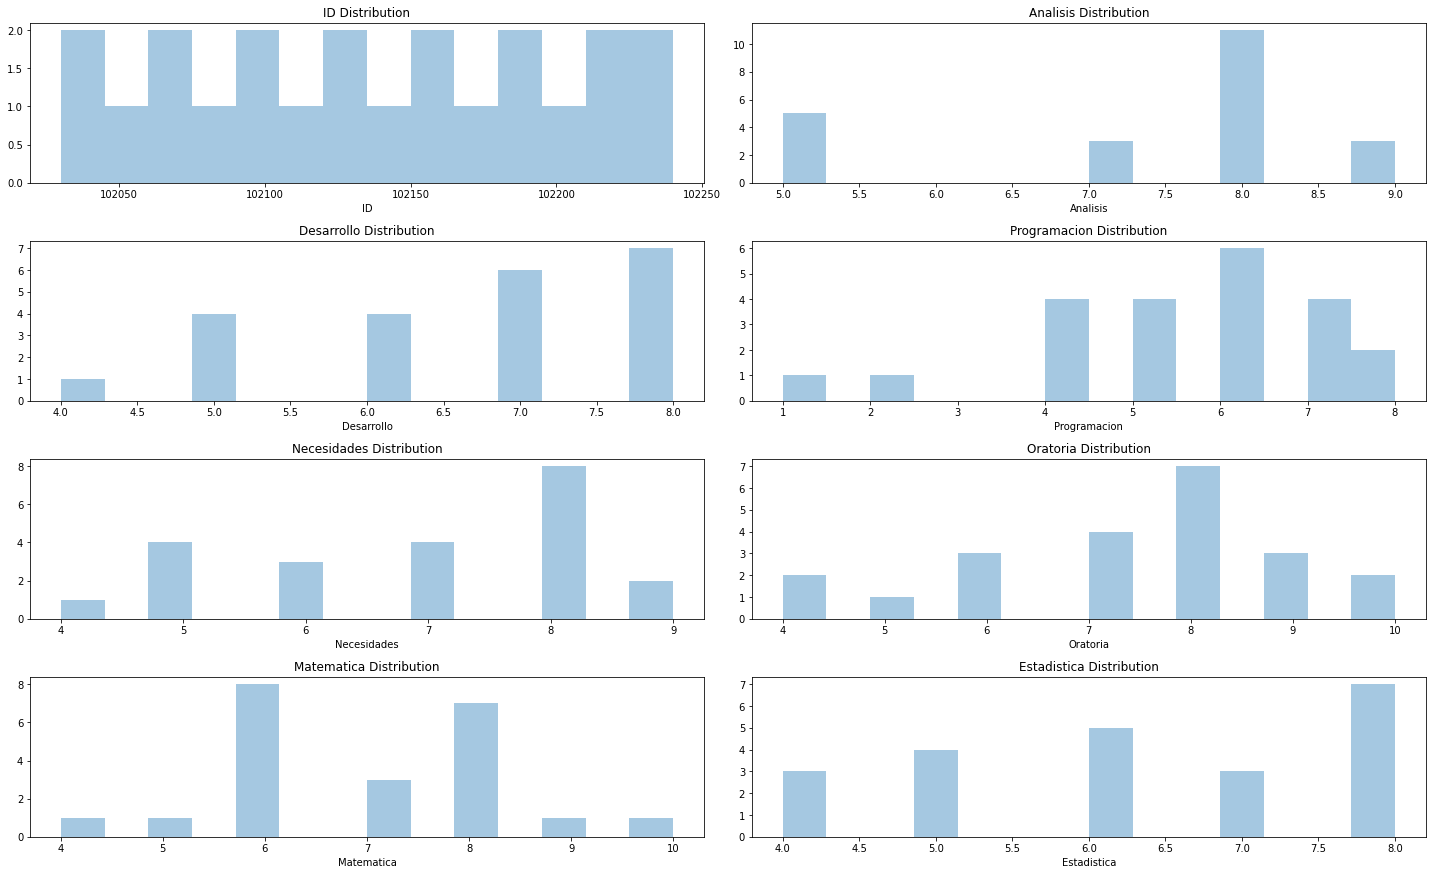

In [7]:
process.grafico_distribucion(process.subset,process.SUBSET_VARS)

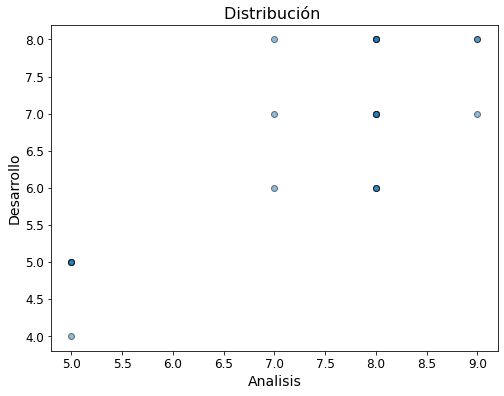

In [8]:
process.grafico_uno(process.subset,var1=process.SUBSET_VARS[1],var2=process.SUBSET_VARS[2])

In [ ]:
process.grafico_uno(process.subset,var1=process.SUBSET_VARS[1],var2=process.SUBSET_VARS[1:],multiple=True)

In [9]:
process.correlacion()

C:\Users\mauricio.cano\AppData\Local\Temp\ipykernel_9552\828075777.py:65: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  return corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,ID,Analisis,Desarrollo,Programacion,Necesidades,Oratoria,Matematica,Estadistica
ID,1.00,-0.14,-0.36,-0.12,0.10,-0.07,-0.32,-0.05
Analisis,-0.14,1.00,0.80,0.22,0.61,0.56,0.45,0.46
Desarrollo,-0.36,0.80,1.00,0.33,0.45,0.63,0.53,0.38
Programacion,-0.12,0.22,0.33,1.00,0.50,0.59,0.57,0.24
Necesidades,0.10,0.61,0.45,0.50,1.00,0.76,0.52,0.24
Oratoria,-0.07,0.56,0.63,0.59,0.76,1.00,0.56,0.07
Matematica,-0.32,0.45,0.53,0.57,0.52,0.56,1.00,0.26
Estadistica,-0.05,0.46,0.38,0.24,0.24,0.07,0.26,1.00


In [10]:
process.escalados

array([[-0.2337232 ,  0.29649973,  0.92329325,  0.77298795,  0.38829014,
         0.03331483, -0.22303855],
       [ 0.50083542,  1.11187397, -0.81777402, -0.64415663, -0.22188008,
        -0.69961143, -1.62499512],
       [ 1.23539404,  1.11187397, -0.23741826,  0.77298795,  0.99846035,
         0.7662411 ,  1.17891803],
       [ 0.50083542,  1.11187397,  0.92329325,  0.77298795,  1.60863057,
         2.23209363, -1.62499512],
       [-0.2337232 , -0.51887452, -1.97848553, -1.35272892, -2.05239073,
        -0.69961143,  0.47793974],
       [-1.70284044, -1.33424877,  0.34293749, -2.0613012 , -2.05239073,
        -0.69961143, -0.22303855],
       [-0.2337232 ,  1.11187397,  1.50364901, -0.64415663,  0.99846035,
         1.49916736,  1.17891803],
       [ 1.23539404,  0.29649973,  0.34293749,  1.48156024,  0.99846035,
        -0.69961143,  1.17891803],
       [-1.70284044, -1.33424877, -0.81777402, -1.35272892, -0.22188008,
        -0.69961143, -0.92401683],
       [ 0.50083542,  1.1118

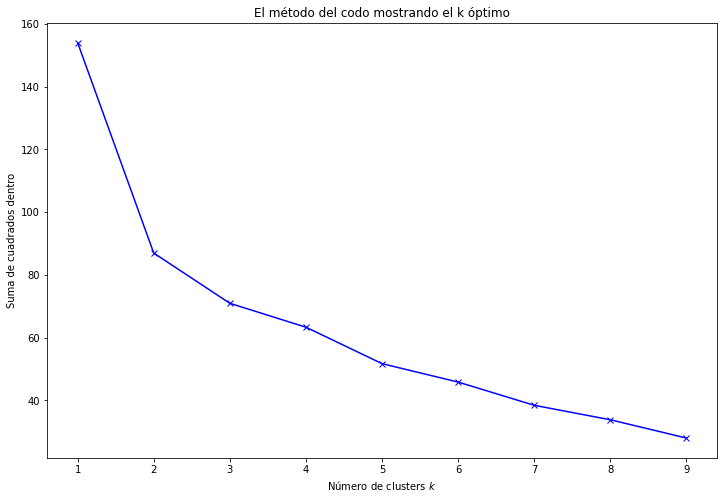

In [11]:
process.data_metodo_codo(modelo="kmeans")

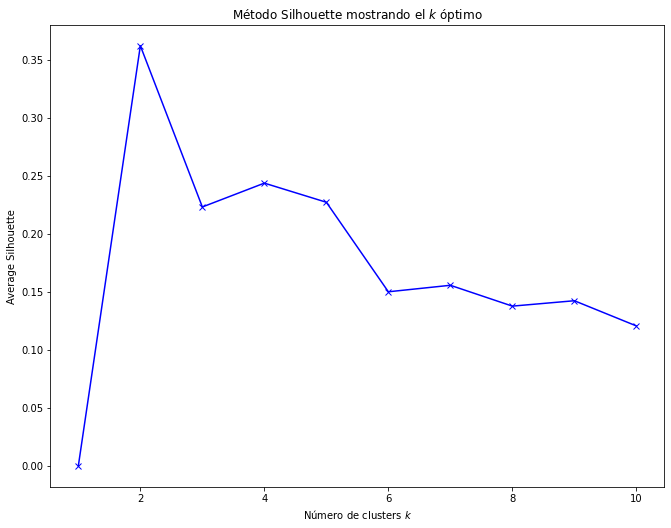

In [12]:
process.data_silueta(modelo="kmeans")

In [ ]:
# process.modelos(modelo="PCA",n_components=2)

In [ ]:
process.modelos(modelo="KNN",n_neighbors=4)

In [ ]:
distances = np.sort(process.knn_distances[:,3], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

In [ ]:
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [ ]:
process.modelos(modelo="dbscan",eps=3.08,min_samples=1)

In [13]:
process.modelos(modelo="kmeans",n_clusters=3)

In [19]:
process.modelos(modelo="jerarquico",n_clusters=3)

In [ ]:
process.data_modelo.groupby('dbscan').mean()

In [14]:
process.data_modelo

,ID,Analisis,Desarrollo,Programacion,Necesidades,Oratoria,Matematica,Estadistica,kmeans
1,102030,7,7,7,8,8,7,6,2
2,102040,8,8,4,6,7,6,4,2
3,102050,9,8,5,8,9,8,8,0
4,102060,8,8,7,8,10,10,4,2
5,102070,7,6,2,5,4,6,7,1
6,102080,5,5,6,4,4,6,6,1
7,102090,7,8,8,6,9,9,8,0
8,102100,9,7,6,9,9,6,8,0
9,102110,5,5,4,5,7,6,5,1
10,102120,8,8,8,8,8,8,8,0


In [15]:
process.data_modelo.groupby('kmeans').mean()

,ID,Analisis,Desarrollo,Programacion,Necesidades,Oratoria,Matematica,Estadistica
kmeans,,,,,,,,
0,102138.888889,8.111111,7.333333,6.111111,7.555556,7.888889,7.555556,7.777778
1,102141.666667,5.833333,5.333333,3.666667,5.000000,5.333333,5.500000,5.666667
2,102124.285714,7.571429,6.857143,6.000000,7.714286,8.428571,7.428571,5.000000


In [16]:
process.data_modelo.groupby('kmeans').count()["ID"]

kmeans
0    9
1    6
2    7
Name: ID, dtype: int64

In [ ]:
plt.figure(figsize=(10,8))
dendrogram = sch.dendrogram(sch.linkage(process.escalados, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Alumnos')
plt.ylabel('Distancias euclideanas')
plt.show()

In [ ]:
process.data_modelo.groupby('jerarquico').mean()

In [ ]:
process.data_modelo.groupby('kmeans').count()["ID"]

In [ ]:
process.data_modelo.groupby('jerarquico').count()["ID"]

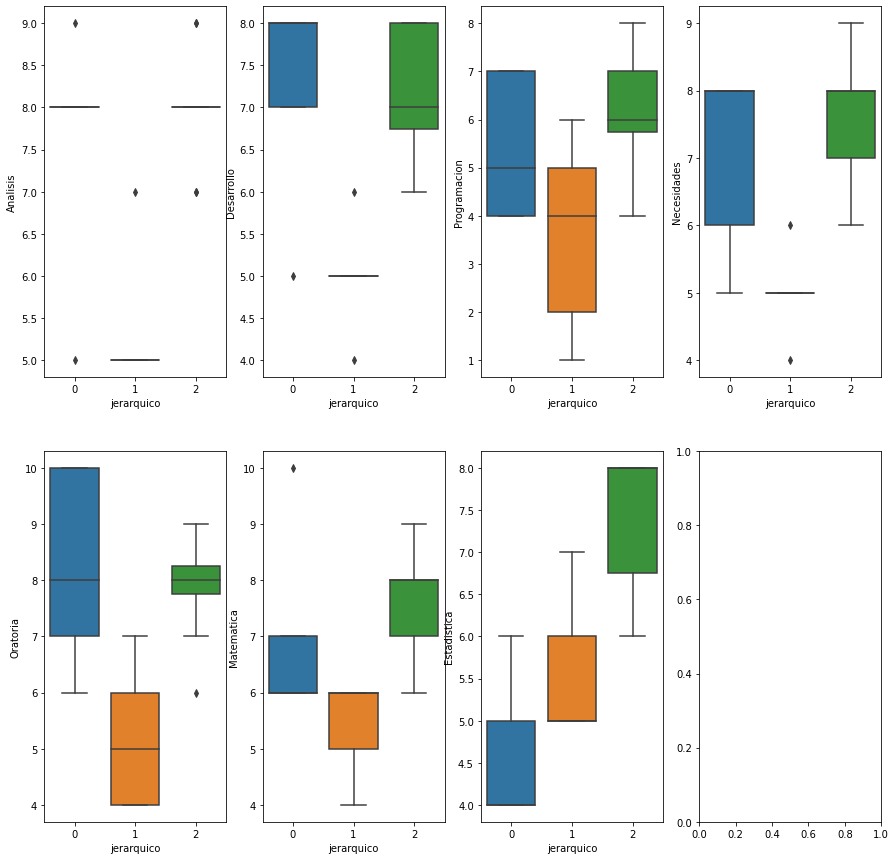

In [24]:
process.boxplot_full(var="jerarquico")

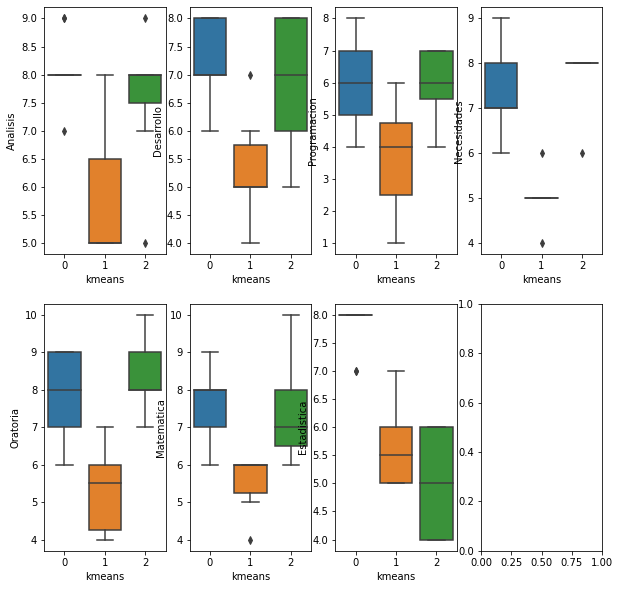

In [17]:
process.boxplot_full(var="kmeans")

In [18]:
# Proyectos
# 8 grupos
grupo_1 = process.data_modelo[process.data_modelo["kmeans"]==0]["ID"].tolist()
grupo_2 = process.data_modelo[process.data_modelo["kmeans"]==1]["ID"].tolist()
grupo_3 = process.data_modelo[process.data_modelo["kmeans"]==2]["ID"].tolist()

lists = [grupo_1,grupo_2,grupo_3]
process.final_teams(lists)

In [19]:
process.data_modelo

,ID,Analisis,Desarrollo,Programacion,Necesidades,Oratoria,Matematica,Estadistica,kmeans,group_n_n
1,102030,7,7,7,8,8,7,6,2,1
2,102040,8,8,4,6,7,6,4,2,2
3,102050,9,8,5,8,9,8,8,0,1
4,102060,8,8,7,8,10,10,4,2,3
5,102070,7,6,2,5,4,6,7,1,1
6,102080,5,5,6,4,4,6,6,1,2
7,102090,7,8,8,6,9,9,8,0,2
8,102100,9,7,6,9,9,6,8,0,3
9,102110,5,5,4,5,7,6,5,1,3
10,102120,8,8,8,8,8,8,8,0,4


In [20]:
process.data_modelo.groupby(["group_n_n","kmeans"]).count()["ID"]

group_n_n  kmeans
1          0         1
           1         1
           2         1
2          0         1
           1         1
           2         1
3          0         1
           1         1
           2         1
4          0         1
           1         1
           2         1
5          0         1
           1         1
           2         1
6          0         1
           1         1
           2         1
7          0         1
           2         1
8          0         2
Name: ID, dtype: int64

In [21]:
process.data_modelo.groupby('group_n_n').mean()

,ID,Analisis,Desarrollo,Programacion,Necesidades,Oratoria,Matematica,Estadistica,kmeans
group_n_n,,,,,,,,,
1,102050.000000,7.666667,7.000000,4.666667,7.000000,7.000000,7.000000,7.000000,1.0
2,102070.000000,6.666667,7.000000,6.000000,5.333333,6.666667,7.000000,6.000000,1.0
3,102090.000000,7.333333,6.666667,5.666667,7.333333,8.666667,7.333333,5.666667,1.0
4,102136.666667,8.000000,7.000000,6.000000,7.000000,7.333333,7.333333,6.666667,1.0
5,102170.000000,7.000000,5.666667,5.000000,6.666667,7.000000,6.666667,6.000000,1.0
6,102196.666667,6.000000,5.666667,4.333333,7.000000,6.666667,6.666667,5.666667,1.0
7,102210.000000,8.500000,8.000000,5.500000,7.500000,9.000000,6.000000,6.500000,1.0
8,102205.000000,8.000000,6.500000,6.500000,8.000000,7.000000,7.500000,7.500000,0.0


In [42]:
process.data_modelo.to_csv("grupos_finales.csv")

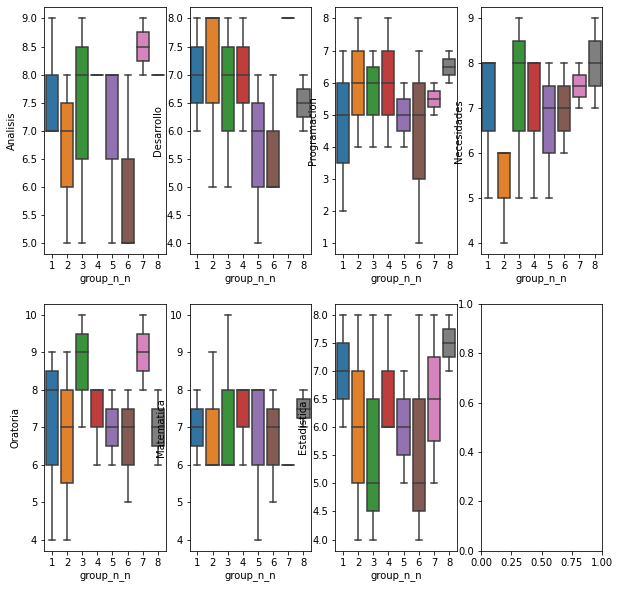

In [22]:
process.boxplot_full(var="group_n_n")

In [24]:
process.data_modelo['Random_group'] = np.random.randint(1,8,size=len(process.data_modelo))

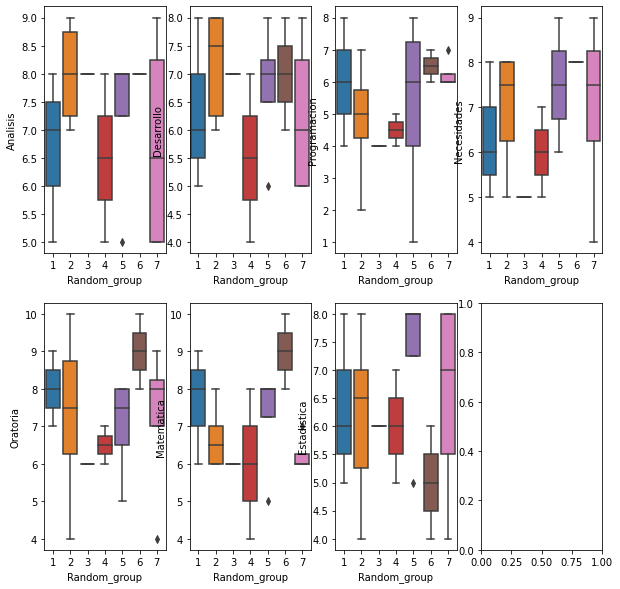

In [25]:
process.boxplot_full(var="Random_group")

In [26]:
process.data_modelo.groupby('Random_group').count()["ID"]

Random_group
1    3
2    6
3    1
4    2
5    4
6    2
7    4
Name: ID, dtype: int64

In [27]:
process.data_modelo.groupby('Random_group').mean()

,ID,Analisis,Desarrollo,Programacion,Necesidades,Oratoria,Matematica,Estadistica,kmeans,group_n_n
Random_group,,,,,,,,,,
1,102120.000000,6.666667,6.333333,6.000000,6.333333,8.000000,7.666667,6.333333,1.000000,3.333333
2,102106.666667,8.000000,7.166667,4.833333,7.000000,7.333333,6.666667,6.166667,1.166667,3.333333
3,102140.000000,8.000000,7.000000,4.000000,5.000000,6.000000,6.000000,6.000000,1.000000,4.000000
4,102175.000000,6.500000,5.500000,4.500000,6.000000,6.500000,6.000000,6.000000,0.500000,5.000000
5,102180.000000,7.250000,6.750000,5.250000,7.500000,7.000000,7.250000,7.250000,0.250000,6.000000
6,102105.000000,8.000000,7.000000,6.500000,8.000000,9.000000,9.000000,5.000000,2.000000,3.500000
7,102137.500000,6.750000,6.250000,6.250000,7.000000,7.250000,6.250000,6.500000,0.750000,4.500000


In [28]:
process.data_modelo.groupby('group_n_n').mean()

,ID,Analisis,Desarrollo,Programacion,Necesidades,Oratoria,Matematica,Estadistica,kmeans,Random_group
group_n_n,,,,,,,,,,
1,102050.000000,7.666667,7.000000,4.666667,7.000000,7.000000,7.000000,7.000000,1.0,2.000000
2,102070.000000,6.666667,7.000000,6.000000,5.333333,6.666667,7.000000,6.000000,1.0,3.333333
3,102090.000000,7.333333,6.666667,5.666667,7.333333,8.666667,7.333333,5.666667,1.0,4.666667
4,102136.666667,8.000000,7.000000,6.000000,7.000000,7.333333,7.333333,6.666667,1.0,4.666667
5,102170.000000,7.000000,5.666667,5.000000,6.666667,7.000000,6.666667,6.000000,1.0,3.000000
6,102196.666667,6.000000,5.666667,4.333333,7.000000,6.666667,6.666667,5.666667,1.0,5.666667
7,102210.000000,8.500000,8.000000,5.500000,7.500000,9.000000,6.000000,6.500000,1.0,4.500000
8,102205.000000,8.000000,6.500000,6.500000,8.000000,7.000000,7.500000,7.500000,0.0,3.500000


In [29]:
list_int = [1, 2, 3,4,5,6,7,8]
process.data_modelo["Random_gr2"] = np.tile(list_int, len(process.data_modelo)//len(list_int) + 1)[:len(process.data_modelo)]

In [30]:
process.data_modelo.groupby('Random_gr2').mean()

,ID,Analisis,Desarrollo,Programacion,Necesidades,Oratoria,Matematica,Estadistica,kmeans,group_n_n,Random_group
Random_gr2,,,,,,,,,,,
1,102110.0,5.666667,5.666667,6.000000,7.000000,7.666667,6.666667,5.000000,1.666667,3.333333,3.333333
2,102120.0,8.000000,7.666667,6.333333,7.666667,7.666667,7.333333,6.666667,0.666667,4.666667,4.000000
3,102130.0,8.333333,7.000000,5.000000,7.333333,7.333333,7.666667,7.333333,0.000000,4.666667,2.666667
4,102140.0,7.000000,6.333333,5.333333,6.000000,7.333333,6.666667,5.000000,1.333333,4.000000,4.333333
5,102150.0,6.666667,5.666667,3.000000,6.333333,5.666667,6.333333,6.000000,1.333333,3.666667,4.333333
6,102160.0,7.333333,6.333333,5.666667,6.666667,7.333333,6.666667,5.666667,1.666667,4.666667,3.333333
7,102130.0,7.500000,7.500000,6.500000,6.500000,8.000000,8.500000,8.000000,0.000000,4.000000,3.000000
8,102140.0,8.500000,7.500000,6.000000,8.000000,8.500000,6.000000,8.000000,0.000000,5.000000,7.000000


In [31]:
process.data_modelo.groupby('Random_gr2').count()["ID"]

Random_gr2
1    3
2    3
3    3
4    3
5    3
6    3
7    2
8    2
Name: ID, dtype: int64

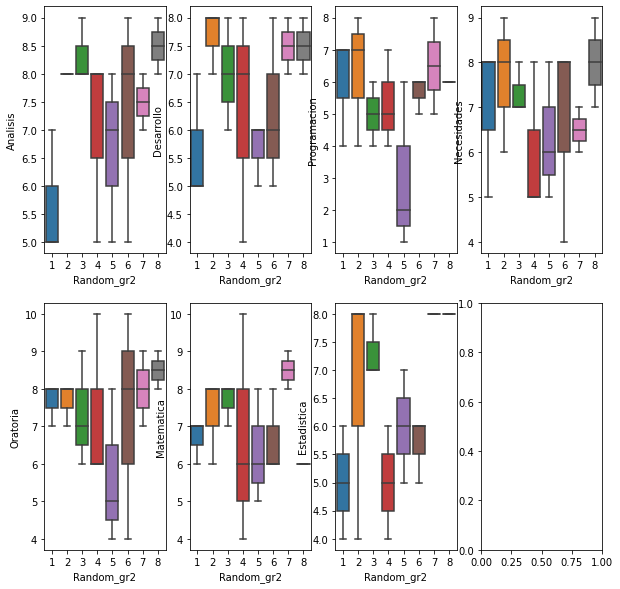

In [32]:
process.boxplot_full(var="Random_gr2")

In [33]:
list_int = [1, 2, 3,4,5,6,7,8]
process.data_modelo.sort_values("ID",inplace=True)
process.data_modelo["Random_gr3"] = np.tile(list_int, len(process.data_modelo)//len(list_int) + 1)[:len(process.data_modelo)]

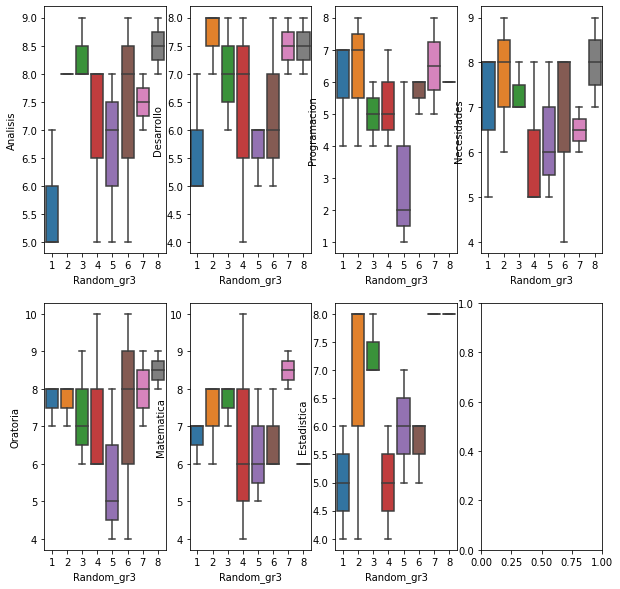

In [34]:
process.boxplot_full(var="Random_gr3")

In [35]:
process.data_modelo.groupby('Random_gr3').mean()

,ID,Analisis,Desarrollo,Programacion,Necesidades,Oratoria,Matematica,Estadistica,kmeans,group_n_n,Random_group,Random_gr2
Random_gr3,,,,,,,,,,,,
1,102110.0,5.666667,5.666667,6.000000,7.000000,7.666667,6.666667,5.000000,1.666667,3.333333,3.333333,1.0
2,102120.0,8.000000,7.666667,6.333333,7.666667,7.666667,7.333333,6.666667,0.666667,4.666667,4.000000,2.0
3,102130.0,8.333333,7.000000,5.000000,7.333333,7.333333,7.666667,7.333333,0.000000,4.666667,2.666667,3.0
4,102140.0,7.000000,6.333333,5.333333,6.000000,7.333333,6.666667,5.000000,1.333333,4.000000,4.333333,4.0
5,102150.0,6.666667,5.666667,3.000000,6.333333,5.666667,6.333333,6.000000,1.333333,3.666667,4.333333,5.0
6,102160.0,7.333333,6.333333,5.666667,6.666667,7.333333,6.666667,5.666667,1.666667,4.666667,3.333333,6.0
7,102130.0,7.500000,7.500000,6.500000,6.500000,8.000000,8.500000,8.000000,0.000000,4.000000,3.000000,7.0
8,102140.0,8.500000,7.500000,6.000000,8.000000,8.500000,6.000000,8.000000,0.000000,5.000000,7.000000,8.0
